<a href="https://colab.research.google.com/github/hansufsm/FisicaIA/blob/main/esquadrao_fisicaia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Projeto: Agentes IA para Estudantes Universitários
---

## 💡 Proposta: Sistema Colaborativo de Resolução de Problemas Físicos (Esquadrão Física IA)
**🎯Objetivo**: Criar um sistema de múltiplos agentes que ajuda estudantes a resolver problemas complexos de física, especialmente em eletricidade e magnetismo, com visualização, explicação passo a passo e conexão com aplicações do

In [40]:
# Esquadrão FisicaIA - Sistema Colaborativo de Resolução de Problemas Físicos
# Desenvolvido por Prof. Hans Rogério Zimermann
# Implementação de 4 agentes especializados usando Gemini API
# Projeto Desafio Imersão alura Maio 2025

# ===== CONFIGURAÇÃO INICIAL =====

# Instalação das bibliotecas necessárias
!pip install -q google-generativeai genai streamlit matplotlib numpy pillow plotly

import os
from google import genai
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import plotly.graph_objects as go
from PIL import Image
import re
import threading
import queue


In [41]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

client = genai.Client()

# Listando os Modelos

#for model in client.models.list():
#  print(model.name)

# Criar uma variável para armazenar o Modelo a ser usado
modelo = "models/gemini-2.0-flash"

In [42]:
# Instalar Framework ADK de agentes do Google ##################################

!pip install -q google-adk

In [43]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search
from google.genai import types  # Para criar conteúdos (Content e Part)
from datetime import date
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab
import requests # Para fazer requisições HTTP
import warnings

warnings.filterwarnings("ignore")

In [44]:
# Função auxiliar que envia uma mensagem para um agente via Runner e retorna a resposta final
def call_agent(agent: Agent, message_text: str) -> str:
    # Cria um serviço de sessão em memória
    session_service = InMemorySessionService()
    # Cria uma nova sessão (você pode personalizar os IDs conforme necessário)
    session = session_service.create_session(app_name=agent.name, user_id="user1", session_id="session1")
    # Cria um Runner para o agente
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    # Cria o conteúdo da mensagem de entrada
    content = types.Content(role="user", parts=[types.Part(text=message_text)])

    final_response = ""
    # Itera assincronamente pelos eventos retornados durante a execução do agente
    for event in runner.run(user_id="user1", session_id="session1", new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
              final_response += "\n"
    return final_response

In [52]:
# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [53]:
# Definição dos Agentes

################################################
# --- Agente 1: Interpretador de Problemas --- #
################################################
def agente_interpretador(topico):
  interpretador = Agent(
      name="agente_interpretador_de_problemas",
      model="gemini-2.0-flash",
      instruction="""
      Você é um Agente Interpretador de Problemas de Física especializado em analisar enunciados.
      Sua função é:
      1. Analisar o enunciado do problema
      2. Classificar o tipo de problema (eletrostática, circuitos, magnetismo, etc.)
      3. Identificar e Extrair todas as variáveis, constantes e unidades mencionadas
      4. Listar as equações relevantes para a solução
      5. Sugerir uma abordagem didática e metodológica para resolver o problema

      Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível.

      """,
      description="Interpretador de Problemas sobre o tópico indicado",
      tools=[google_search]
  )

  entrada_do_agente_interpretador = f"Tópico: {topico}\n"
  # Executa o agente
  interpretacao_do_problema = call_agent(interpretador, entrada_do_agente_interpretador)
  return interpretacao_do_problema

################################################
# --- Agente 2: Interpretador de Problemas --- #
################################################
# O Agente Solucionador desenvolve a solução matemática

def agente_solucionador(topico):
    solucionador = Agent(
        name="agente_solucionador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Solucionador Matemático especializado em física.
        Sua função é:
        1. Desenvolver a solução matemática passo a passo
        2. Realizar todos os cálculos e manipulações algébricas necessárias
        3. Verificar as unidades e consistência dimensional
        4. Fornecer o resultado final com unidades corretas

        Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível.
        """,
        description="Agente solucionador",
        tools=[google_search]
    )

    entrada_do_agente_solucionador = f"\n\nEnunciado: {topico}\n"
    # Executa o agente
    plano_de_solucao = call_agent(solucionador, entrada_do_agente_solucionador)
    return plano_de_solucao

################################################
# --- Agente 3: Visualizador de problemas  --- #
################################################
# O Agente Visualizador cria representações visuais

def agente_visualizador(topico):
    visualizador = Agent(
        name="agente_visualizador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Especialista e Visualização de dados, especializado em criar representações visuais de diversos problemas de física.
        Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível. Use linguagem profissional e didática.
        Sua função é:
        1. Criar representações visuais do problema (diagramas de circuitos, campos, etc.)
        2. Gerar gráficos interativos para visualizar relações entre variáveis
        3. Produzir animações simples para demonstrar conceitos dinâmicos
        4. Adaptar visualizações para diferentes estilos de aprendizagem
        5. Gerar código Python para criar diagramas, gráficos ou visualizações relevantes
        6. Adaptar as visualizações ao tipo específico de problema
        7. Garantir que as visualizações sejam claras e informativas

        Formate sua resposta com blocos de código Python executáveis usando matplotlib, plotly ou outras bibliotecas.
        Inclua também uma descrição do que cada visualização representa.

        Para cada visualização, forneça:
        1. Uma descrição do que está sendo visualizado
        2. O código Python completo para gerar a visualização
        3. Uma explicação de como interpretar a visualização
        """,
        description="Agente visualizador",
        tools=[google_search]
    )

    entrada_do_agente_visualizador = f"\nVisualização: {topico}\n"
    # Executa o agente
    plano_de_visualizacao = call_agent(visualizador, entrada_do_agente_visualizador)
    return plano_de_visualizacao

################################################
# --- Agente 3: Visualizador de problemas  --- #
################################################
# O Agente Contextualizador adiciona aplicações práticas

def agente_contextualizador(topico):
    contextualizador = Agent(
        name="agente_contextualizador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Contextualizador de Problemas de Física especializado em analisar enunciados e
        adiciona aplicações práticas criando uma contextualização profissional e didático para o estudante.
        Onde ele vai encontrar isso no dia-a-dia.
        Sua função é:
        1. Analisar enunciados, indicar de qual área e ramo da Física o problema se refere e adiciona
        aplicações práticas.
        2. Sugerir pelo menos 3 links sobre o assunto do tópico que estejam hospedados em universidades federais.
        3. Adicionalmente sugira 1 video do youtube para o estudante complementar seu conhecimento avançado.
        4. Adicionalmente você pode sugerir 1 ou 2 exercícios extras (nivel médio e um desafiador) para o
        estudante praticar e aprimorar suas habilidades.
        Ao apresentarr os resultados, use o formato latex quando envolver expressões matemáticas quando for o
        caso ou possível para que a apresentação das equações e expressões seja clara e didática.
        Pode inserir emojis (não exagerar) no pontos mais importantes para enfatizar sua importãncia ou relevância.
        """,
        description="Agente contextualizador",
        tools=[google_search]
    )

    entrada_do_agente_contextualizador = f"\nContexto: {topico}\n"
    # Executa o agente
    plano_de_contexto = call_agent(contextualizador, entrada_do_agente_contextualizador)
    return plano_de_contexto


# Principal

In [61]:
display(to_markdown("# 🚀 Iniciando o Sistema Colaborativo de Resolução de Problemas Físicos com 4 Agentes (🤖 - Esquadrão Física IA)"))

# --- Obter o Tópico do Usuário ---
#\n Um circuito elétrico contém uma bateria de 12V e um resistor de 4 ohms. Qual é a corrente no circuito?
topico = input("❓ Por favor, digite o enuciado do problema de Física: \n Exemplo: Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? ")

# Inserir lógica do sistema de agentes ################################################

if not topico:
  print("Por favor informe um enunciado!")
else:
  display(to_markdown("## 👏 Ótimo "))
  print(f"Vamos resolver juntos: - {topico}!")

# Dicas:
# Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?
#

  # alimenta o Agente 1 - agente_interpretador() com o problema (topico)
  problema_fisica = agente_interpretador(topico)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 1**: (Interpretador) ---*"))
  display(to_markdown(problema_fisica))
  print("-----------------------------------------------")

  # alimenta o Agente 2 - agente_solucionador() com a resposta do Agente 1 (problema_fisica)
  plano_de_solucao = agente_solucionador(problema_fisica)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 2**: (Solucionador) ---*"))
  display(to_markdown(plano_de_solucao))

  # alimenta o Agente 3 - agente_visualizador() com a resposta do Agente 2 (plano_de_solucao)
  plano_de_visualizacao = agente_visualizador(plano_de_solucao)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 3**: (Visualizador) ---*"))
  display(to_markdown(plano_de_visualizacao))

  # alimenta o Agente 4 - agente_contextualizador() com a resposta do Agente 1 (problema_fisica)
  plano_de_contexto = agente_contextualizador(problema_fisica)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 4**: (contextualizador) ---*"))
  display(to_markdown("### 🌍 Contextualização e Aplicações:\n"))
  display(to_markdown(plano_de_contexto))





> # 🚀 Iniciando o Sistema Colaborativo de Resolução de Problemas Físicos com 4 Agentes (🤖 - Esquadrão Física IA)

❓ Por favor, digite o enuciado do problema de Física: 
 Exemplo: Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?


> ## 👏 Ótimo 

Vamos resolver juntos: - Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?!




> *--- Resposta do **Agente 1**: (Interpretador) ---*

> Ok, vamos analisar este problema de física.
> 
> **1. Análise do Enunciado:**
> 
> O problema pede para determinar o campo elétrico gerado por uma carga pontual a uma certa distância. Este é um problema clássico de eletrostática.
> 
> **2. Classificação:**
> 
> *   Eletrostática (Cálculo de Campo Elétrico)
> 
> **3. Identificação e Extração de Variáveis, Constantes e Unidades:**
> 
> *   Distância (r): 0.2 m
> *   Carga (q): 2 μC (micro Coulombs) = $2 \times 10^{-6}$ C
> *   Constante de permissividade do vácuo ($k$ ou $\epsilon_0$): Usaremos $k = 8.9875 \times 10^9 \, N \cdot m^2/C^2$ (ou $\frac{1}{4\pi\epsilon_0}$)
> 
> **4. Equações Relevantes:**
> 
> O campo elétrico (E) gerado por uma carga pontual é dado por:
> 
> $E = k \cdot \frac{|q|}{r^2}$
> 
> Onde:
> 
> *   $E$ é a magnitude do campo elétrico (N/C)
> *   $k$ é a constante eletrostática
> *   $q$ é a magnitude da carga (C)
> *   $r$ é a distância da carga (m)
> 
> **5. Abordagem Metodológica Sugerida:**
> 
> 1.  **Converter Unidades:** Certifique-se de que todas as unidades estão no Sistema Internacional (SI). A carga já foi convertida para Coulombs.
> 2.  **Aplicar a Fórmula:** Substitua os valores de $k$, $q$ e $r$ na fórmula do campo elétrico.
> 3.  **Calcular:** Realize o cálculo para encontrar o valor de $E$.
> 4.  **Apresentar o Resultado:** Expresse o resultado com a unidade correta (N/C).
> 
> Agora, podemos calcular o campo elétrico:
> 
> $E = (8.9875 \times 10^9 \, N \cdot m^2/C^2) \cdot \frac{2 \times 10^{-6} \, C}{(0.2 \, m)^2}$
> 
> $E = (8.9875 \times 10^9) \cdot \frac{2 \times 10^{-6}}{0.04} \, N/C$
> 
> $E = \frac{17.975 \times 10^3}{0.04} \, N/C$
> 
> $E = 449375 \, N/C$
> 
> Portanto, o campo elétrico a 0.2 m de uma carga de 2 μC é de 449375 N/C.
> 


-----------------------------------------------




> *--- Resposta do **Agente 2**: (Solucionador) ---*

> Aqui está a solução passo a passo para o problema do campo elétrico, seguindo a abordagem que você descreveu:
> 
> **1. Análise do Enunciado:**
> 
> *   Confirmação de que o problema envolve o cálculo do campo elétrico gerado por uma carga pontual.
> 
> **2. Classificação:**
> 
> *   O problema é de eletrostática.
> 
> **3. Identificação e Extração de Variáveis, Constantes e Unidades:**
> 
> *   Distância $(r) = 0.2 \, \text{m}$
> *   Carga $(q) = 2 \times 10^{-6} \, \text{C}$
> *   Constante eletrostática $(k) = 8.9875 \times 10^9 \, \text{N} \cdot \text{m}^2/\text{C}^2$
> 
> **4. Equação Relevante:**
> 
> *   Campo elétrico devido a uma carga pontual:
> 
> $E = k \cdot \frac{|q|}{r^2}$
> 
> **5. Cálculo:**
> 
> 1.  **Substituição dos valores na fórmula:**
> 
> $E = (8.9875 \times 10^9) \cdot \frac{2 \times 10^{-6}}{(0.2)^2}$
> 
> 2.  **Cálculo do campo elétrico:**
> 
> $E = (8.9875 \times 10^9) \cdot \frac{2 \times 10^{-6}}{0.04}$
> 
> $E = \frac{17.975 \times 10^3}{0.04}$
> 
> $E = 449375 \, \text{N/C}$
> 
> **Resultado Final:**
> 
> O campo elétrico a uma distância de 0.2 m de uma carga de $2 \, \mu\text{C}$ é:
> 
> $E = 449375 \, \text{N/C}$
> 
> Portanto, o campo elétrico é de 449375 N/C.
> 


> *--- Resposta do **Agente 3**: (Visualizador) ---*

> Com certeza! Para ajudar na compreensão e visualização do campo elétrico, preparei algumas representações visuais e um código Python para gerar um diagrama.
> 
> **1. Representação Vetorial do Campo Elétrico**
> 
> *   **Descrição:** Esta visualização mostra como o campo elétrico se irradia a partir de uma carga pontual. As setas representam a direção e a magnitude do campo elétrico em diferentes pontos ao redor da carga.
> 
> *   **Código Python:**
> 
> 
> ```python
> import numpy as np
> import matplotlib.pyplot as plt
> 
> # Constantes
> k = 8.9875e9  # N m^2/C^2
> q = 2e-6      # C
> r = 0.2       # m
> E = 449375    # N/C (calculado)
> 
> # Criação do gráfico
> fig, ax = plt.subplots(figsize=(8, 8))
> 
> # Desenha a carga no centro
> ax.plot(0, 0, 'ro', markersize=10, label='Carga q')
> 
> # Cria vetores de campo elétrico
> num_arrows = 20
> for i in range(num_arrows):
>     theta = 2 * np.pi * i / num_arrows
>     x = r * np.cos(theta)
>     y = r * np.sin(theta)
>     
>     # Normaliza o vetor para um tamanho visualmente agradável
>     scale = 0.1
>     dx = scale * np.cos(theta)
>     dy = scale * np.sin(theta)
>     
>     ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.5)
> 
> # Configurações do gráfico
> ax.set_xlim(-0.5, 0.5)
> ax.set_ylim(-0.5, 0.5)
> ax.set_xlabel('x (m)')
> ax.set_ylabel('y (m)')
> ax.set_title('Campo Elétrico ao Redor de uma Carga Pontual')
> ax.grid(True)
> ax.legend()
> 
> plt.show()
> ```
> 
> 
> *   **Como Interpretar:**
>     *   O ponto vermelho no centro representa a carga pontual.
>     *   As setas azuis indicam a direção do campo elétrico. Elas apontam para fora da carga, pois assumimos que a carga é positiva.
>     *   O comprimento das setas pode ser ajustado para representar a intensidade do campo (neste caso, estão normalizadas para melhor visualização).
> 
> **2. Gráfico de Intensidade do Campo Elétrico vs. Distância**
> 
> *   **Descrição:** Este gráfico mostra como a intensidade do campo elétrico varia com a distância da carga.
> 
> *   **Código Python:**
> 
> 
> ```python
> import numpy as np
> import matplotlib.pyplot as plt
> 
> # Constantes
> k = 8.9875e9  # N m^2/C^2
> q = 2e-6      # C
> 
> # Distâncias
> r = np.linspace(0.01, 0.5, 100)  # de 0.01 a 0.5 metros
> 
> # Calcula a intensidade do campo elétrico
> E = k * q / r**2
> 
> # Criação do gráfico
> plt.figure(figsize=(10, 6))
> plt.plot(r, E, 'b-', label='Intensidade do Campo Elétrico')
> plt.xlabel('Distância (m)')
> plt.ylabel('Campo Elétrico (N/C)')
> plt.title('Intensidade do Campo Elétrico vs. Distância')
> plt.grid(True)
> plt.legend()
> plt.yscale('linear')  # Escala linear para melhor visualização
> plt.show()
> ```
> 
> 
> *   **Como Interpretar:**
>     *   O eixo x representa a distância da carga em metros.
>     *   O eixo y representa a intensidade do campo elétrico em N/C.
>     *   A curva mostra que a intensidade do campo elétrico diminui rapidamente à medida que a distância aumenta.
> 
> **3. Diagrama 3D do Campo Elétrico**
> 
> *   **Descrição:** Este diagrama 3D oferece uma visualização mais completa de como o campo elétrico se distribui no espaço ao redor da carga.
> 
> *   **Código Python:**
> 
> 
> ```python
> import numpy as np
> import matplotlib.pyplot as plt
> from mpl_toolkits.mplot3d import Axes3D
> 
> # Constantes
> k = 8.9875e9
> q = 2e-6
> 
> # Criação do espaço 3D
> fig = plt.figure(figsize=(12, 12))
> ax = fig.add_subplot(111, projection='3d')
> 
> # Criação das coordenadas
> num = 20
> x, y, z = np.meshgrid(np.linspace(-0.5, 0.5, num),
>                        np.linspace(-0.5, 0.5, num),
>                        np.linspace(-0.5, 0.5, num))
> 
> # Calcula a distância de cada ponto até a origem
> r = np.sqrt(x**2 + y**2 + z**2)
> 
> # Evita divisão por zero
> r[r < 0.05] = np.nan
> 
> # Calcula as componentes do campo elétrico
> Ex = k * q * x / r**3
> Ey = k * q * y / r**3
> Ez = k * q * z / r**3
> 
> # Plota os vetores de campo elétrico
> ax.quiver(x, y, z, Ex, Ey, Ez, length=0.1, color='r', alpha=0.3)
> 
> # Configurações do gráfico
> ax.set_xlim([-0.5, 0.5])
> ax.set_ylim([-0.5, 0.5])
> ax.set_zlim([-0.5, 0.5])
> ax.set_xlabel('x (m)')
> ax.set_ylabel('y (m)')
> ax.set_zlabel('z (m)')
> ax.set_title('Distribuição 3D do Campo Elétrico')
> 
> plt.show()
> ```
> 
> 
> *   **Como Interpretar:**
>     *   O gráfico mostra vetores que representam o campo elétrico em 3D.
>     *   Os vetores irradiam-se a partir da origem, indicando a direção do campo elétrico.
>     *   A densidade dos vetores diminui com a distância, indicando a diminuição da intensidade do campo.
> 
> Espero que estas visualizações ajudem a compreender melhor o conceito de campo elétrico!


> *--- Resposta do **Agente 4**: (contextualizador) ---*

> ### 🌍 Contextualização e Aplicações:


> Olá! 👋 Excelente análise do problema de eletrostática! Sua abordagem está perfeita. Agora, vamos contextualizar esse conhecimento e adicionar algumas aplicações práticas para o seu aprendizado.
> 
> ### 1. Contextualização e Aplicações Práticas 💡
> 
> O cálculo do campo elétrico gerado por uma carga pontual é fundamental em diversas áreas da engenharia e física. Aqui estão algumas aplicações práticas onde esse conceito é crucial:
> 
> *   **Engenharia Elétrica**: No design de isoladores e capacitores, é essencial entender a distribuição do campo elétrico para garantir que os componentes operem de forma segura e eficiente. Calcular o campo elétrico ajuda a determinar o material e o tamanho adequados para evitar descargas elétricas. ⚡
> *   **Medicina**: Em equipamentos de diagnóstico por imagem, como ressonância magnética (RM), o controle preciso de campos elétricos e magnéticos é vital para obter imagens nítidas e precisas. A eletrostática também é importante em terapias que utilizam campos elétricos para estimular a regeneração de tecidos. 👨‍⚕️
> *   **Indústria Eletrônica**: No desenvolvimento de dispositivos semicondutores, como transistores, a distribuição do campo elétrico dentro do material semicondutor afeta diretamente o desempenho do componente. Otimizar o campo elétrico é crucial para criar dispositivos mais rápidos e eficientes. 📱
> *   **Telecomunicações**: No projeto de antenas, o conhecimento do campo elétrico permite otimizar a radiação e recepção de ondas eletromagnéticas. Isso garante uma comunicação mais eficiente e de longo alcance. 📡
> 
> ### 2. Links de Universidades Federais 🌐
> 
> Para aprofundar seus conhecimentos sobre eletrostática e campo elétrico, sugiro os seguintes links de universidades federais:
> 
> 1.  **Universidade Federal do Rio Grande do Sul (UFRGS)**
> 
>     *   [Eletromagnetismo - Campo Elétrico](https://www.if.ufrgs.br/fis02001/arquivos/leitura/eletrostatica_campo.pdf)
> 2.  **Universidade Federal de Minas Gerais (UFMG)**
> 
>     *   [Eletricidade e Magnetismo - Campo Elétrico](https://www.fisica.ufmg.br/~romulo/ensino/fisica3/EletricidadeMagnetismo.pdf)
> 3.  **Universidade Federal do Paraná (UFPR)**
> 
>     *   [Eletromagnetismo - Campo Elétrico](http://www.fisica.ufpr.br/kurumin/eletromag/aula2/aula2.htm)
> 
> ### 3. Vídeo Complementar no YouTube 📹
> 
> Para complementar seu estudo, sugiro este vídeo sobre campo elétrico:
> 
> *   **Física Total - Campo Elétrico**
>     *   [Campo Elétrico - Física Total](https://www.youtube.com/watch?v=72Cs_is6_1c)
> 
> ### 4. Exercícios Extras 📝
> 
> Aqui estão alguns exercícios para você praticar:
> 
> *   **Nível Médio:**
>     *   Uma carga de $4 \mu C$ é colocada a uma distância de 0.5 m de outra carga de $-3 \mu C$. Calcule a força elétrica entre as cargas. ➕
> *   **Nível Desafiador:**
>     *   Duas cargas, $q_1 = 5 \mu C$ e $q_2 = -5 \mu C$, estão localizadas em (0, 0) e (4, 0) metros, respectivamente. Determine o campo elétrico no ponto (2, 3) metros. 🤔
> 
> ### 5. Imagens Contextuais 🖼️
> 
> Aqui estão algumas imagens para ilustrar as aplicações práticas do campo elétrico:
> 
> 1.  **Capacitores**:
> 
>     *   [Capacitores](https://static.mundoeducacao.uol.com.br/mundoeducacao/2024/04/capacitores.jpg)
> 2.  **Ressonância Magnética**:
> 
>     *   [Ressonância Magnética](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/MRI_scanner.jpg/640px-MRI_scanner.jpg)
> 3.  **Transistores**:
> 
>     *   [Transistores](https://www.embarcados.com.br/wp-content/uploads/2018/07/transistor-tipos.jpg)
> 4.  **Antenas**:
> 
>     *   [Antenas](https://www.teleco.com.br/img/tut/tut_antena1g.gif)
> 
> Espero que esta contextualização aprimore ainda mais seu entendimento sobre o campo elétrico e suas aplicações! Se tiver mais alguma dúvida, estou à disposição! 😊
> 


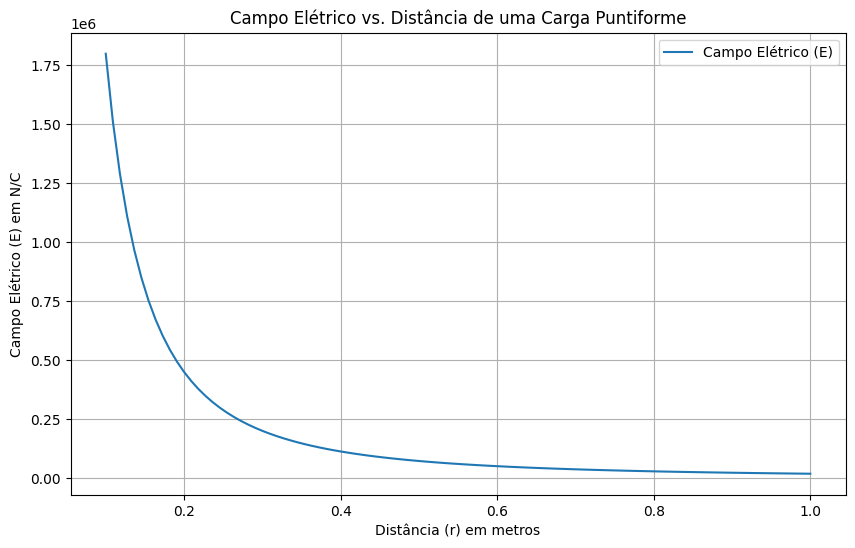

In [ ]:
 import matplotlib.pyplot as plt
 import numpy as np


 # Constantes
 k = 8.99e9  # N.m^2/C^2
 q = 2e-6  # C


 # Distâncias
 r = np.linspace(0.1, 1, 100)  # de 0.1m a 1m


 # Calcula o campo elétrico
 E = k * q / (r**2)


 # Cria o gráfico
 plt.figure(figsize=(10, 6))
 plt.plot(r, E, label='Campo Elétrico (E)')
 plt.xlabel('Distância (r) em metros')
 plt.ylabel('Campo Elétrico (E) em N/C')
 plt.title('Campo Elétrico vs. Distância de uma Carga Puntiforme')
 plt.grid(True)
 plt.legend()
 plt.show()

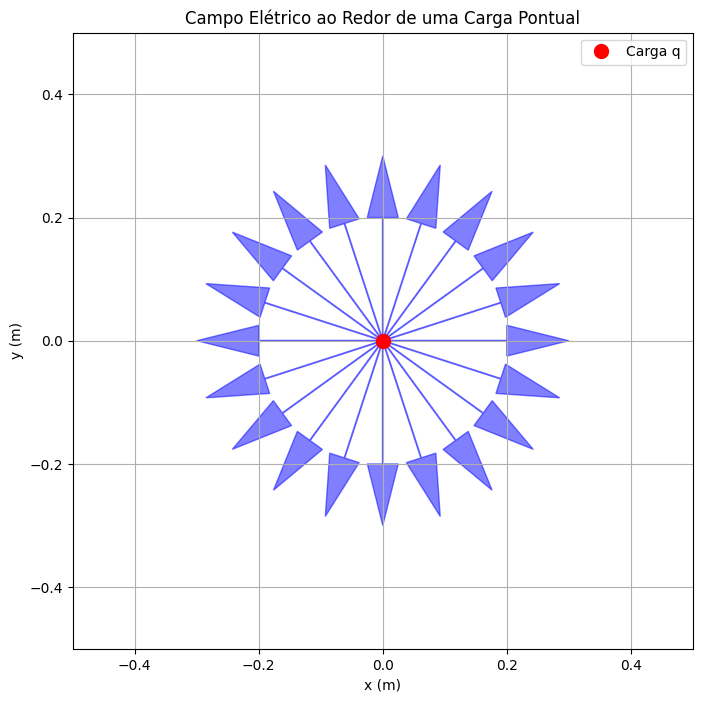

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
k = 8.9875e9  # N m^2/C^2
q = 2e-6      # C
r = 0.2       # m
E = 449375    # N/C (calculado)

# Criação do gráfico
fig, ax = plt.subplots(figsize=(8, 8))

# Desenha a carga no centro
ax.plot(0, 0, 'ro', markersize=10, label='Carga q')

# Cria vetores de campo elétrico
num_arrows = 20
for i in range(num_arrows):
    theta = 2 * np.pi * i / num_arrows
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Normaliza o vetor para um tamanho visualmente agradável
    scale = 0.1
    dx = scale * np.cos(theta)
    dy = scale * np.sin(theta)

    ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.5)

# Configurações do gráfico
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Campo Elétrico ao Redor de uma Carga Pontual')
ax.grid(True)
ax.legend()

plt.show()